In [1]:
import numpy
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import numpy as np
from config import *


c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## load data

In [2]:
from config import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import all charging power predictions from directory
df_list = []
for file in os.listdir(result_directory + os.sep + "generatePredictions"):
    if file.endswith(".csv"):
        df_loaded = pd.read_csv(result_directory + os.sep + "generatePredictions" + os.sep + file, index_col = 0)
        # append one column to the dataframe
        df_list.append(df_loaded)

choose_column = "Power_original"

In [3]:
# get taz number of each charging station
taz_list = []
for file in os.listdir(result_directory + os.sep + "generatePredictions"):
    if file.endswith(".csv"):
        taz_list.append(file.split(".")[0])

In [4]:
def construct_numpy_array(df_list, choose_column):
    # construct numpy array
    array = np.zeros((len(df_list), len(df_list[0]))) # vector of shape (number of charging stations, number of time steps)
    timevector = df_list[0]["time"].to_numpy()
    for i in range(len(df_list)):
        array[i] = df_list[i][choose_column]
    return array, timevector

array, timevector = construct_numpy_array(df_list, "Power_original")

#### plot all predictions

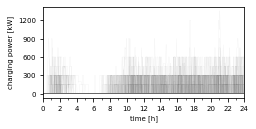

In [5]:
# plot all charging power predictions in one figure
plt.figure()
pltSettings()
# set the color of the lines
colors = plt.cm.jet(np.linspace(0,1,array.shape[0]))
for i in range(array.shape[0]):
    plt.plot(timevector/3600, array[i], color = 'dimgrey', alpha = 0.15, linewidth = 0.2)
plt.xlabel("time [h]")
plt.ylabel("charging power [kW]")
#plt.title("Charging power predictions")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, array.max(), 300))
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.4* plotSizeY) #6.6, 2.7)

# save figure as pdf
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight')

## k means dtw

In [14]:
timestep_in_min_new = 15
calc_cumulative_power = True
timestep_new = timestep_in_min_new*60 # 15 minutes
timevector_new = np.arange(1, 24*3600, timestep_new)
array_new = np.zeros((array.shape[0], len(timevector_new)))
for i in range(array.shape[0]):# loop through charging station
    j0 = 0
    for j in range(len(timevector_new)):# loop through time steps
        if calc_cumulative_power:
            array_new[i,j] = sum(array[i, 0:j0+timestep_in_min_new]*timestep_new/3.6e3) # to calculate power, multiply with timestep/3.6e3 in kWh
        else:
            array_new[i,j] = sum(array[i, j0:j0+timestep_in_min_new]*timestep/3.6e3) # to calculate energy, multiply with timestep/3.6e3 in kWh
        j0 = j0 + timestep_in_min_new

In [18]:
# plot all charging power predictions in one figure
plt.figure()
pltSettings()
%matplotlib qt
# set the color of the lines
colors = plt.cm.jet(np.linspace(0,1,array.shape[0]))
for i in range(array.shape[0]):
    plt.plot(timevector_new/3600, array_new[i], color = 'dimgrey', alpha = 0.6, linewidth = 0.2)
plt.xlabel("time [h]")
plt.ylabel("charging power [kW]")
#plt.title("Charging power predictions")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
#ax.set_yticks(np.arange(0, array_new.max(), 300))
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.4* plotSizeY) #6.6, 2.7)

# save figure as pdf
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight')

In [29]:
import tqdm
n_clusters_list = np.arange(2, 5, 1)
dba_km_list = []
cluster_found_list=[]
silhouette_scores = []

X = TimeSeriesScalerMeanVariance().fit_transform(array_new)

for n_clusters in tqdm.tqdm(n_clusters_list):
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw_", verbose=True, n_jobs = -1)
    #dba_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True, n_jobs = -1)
    cluster_found = dba_km.fit_predict(X)
    cluster_found_list.append(cluster_found)
    silhouette_scores.append(dba_km.inertia_)
    dba_km_list.append(dba_km)

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.2s finished


5.071 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.5s finished


2.204 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.3s finished


2.195 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.5s finished


2.195 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 318 out of 318 | elapsed:    0.5s finished
 33%|███▎      | 1/3 [00:16<00:33, 16.98s/it][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | e

4.397 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.6s finished


1.984 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.8s finished


1.958 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    1.0s finished


1.956 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.7s finished


1.956 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    0.5s finished
 67%|██████▋   | 2/3 [00:36<00:18, 18.34s/it][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 477 out of 477 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 conc

3.838 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.4s finished


1.890 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.3s finished


1.818 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.4s finished


1.789 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.5s finished


1.773 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.3s finished


1.752 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.4s finished


1.744 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.4s finished


1.738 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.8s finished


1.735 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.5s finished


1.734 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.5s finished


1.731 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.7s finished


1.731 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 636 out of 636 | elapsed:    0.8s finished
100%|██████████| 3/3 [01:00<00:00, 20.29s/it]


Text(0.5, 1.0, 'Silhouette scores')

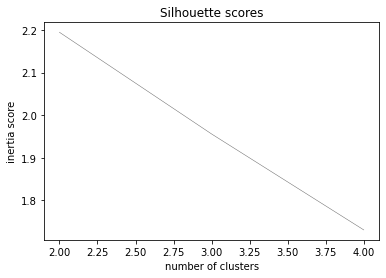

In [30]:
%matplotlib inline
plt.figure
plt.plot(n_clusters_list, silhouette_scores, color = 'dimgrey', linewidth = 0.5)
plt.xlabel("number of clusters")
plt.ylabel("inertia score")
plt.title("Silhouette scores")

In [ ]:
# plot clusters
%matplotlib qt
n_clusters = 4
n_clusters_real = n_clusters-2
dba_km = dba_km_list[n_clusters_real]
cluster_found = cluster_found_list[n_clusters_real]
cluster_found = pd.Series(cluster_found, name = "cluster")

fig, ax = plt. subplots(1,n_clusters)
color_list = plt.cm.hsv(np.linspace(0,1,n_clusters))
df_array = pd.DataFrame(array_new)

for i in range(n_clusters):
    cluster = cluster_found[cluster_found == i]
    for j in cluster.index:
        ax[i].step(timevector_new/3600, X[j], color = color_list[i], alpha = 0.15, linewidth = 1)
    cluster = cluster_found[cluster_found == i]
    #ax[i].plot(timevector_new/3600, array_new[cluster.index].median(axis = 0), color = color_list[i], linewidth = 4)
    ax[i].plot(timevector_new/3600, dba_km.cluster_centers_[i].ravel(), color = color_list[i], linewidth = 2)
    # make color a bit darker

fig.set_size_inches(15,4)